In [31]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import copy
import sklearn
import rastermap
import pandas as pd

import tensorly as tl
import tensorly.decomposition

In [3]:
dir_github        = Path(r'/n/data1/hms/neurobio/sabatini/gyu/github_clone').resolve()

dir_analysisFiles = Path(r'/n/data1/hms/neurobio/sabatini/gyu/data_done/mouse_1511L/20230111/analysis_data').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p         = Path(r'/n/data1/hms/neurobio/sabatini/gyu/data_done/mouse_1511L/20230111/analysis_data/suite2p/plane0').resolve()
# dir_s2p         = Path(r'C:\Users\Rich Hakim\Downloads\F.npy').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


dir_save       =  copy.copy(dir_analysisFiles)
path_save = dir_save / 'weights_day0'
# path_save = dir_save / 'weights_day0_PC2'

In [10]:
!git pull

remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 13 (delta 10), reused 13 (delta 10), pack-reused 0
Unpacking objects: 100% (13/13), done.
From https://github.com/RichieHakim/basic_neural_processing_modules
   13e363d..7fea24c  main       -> origin/main
Updating 13e363d..7fea24c
Fast-forward
 bnpm/similarity.py     | 72 +++++++++++++++++++++++++++-----------------------
 bnpm/tests/test_all.py | 37 +++++++++++++++++++++++++-
 2 files changed, 75 insertions(+), 34 deletions(-)


In [11]:
import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2

from bnpm import torch_helpers, file_helpers, timeSeries, ca2p_preprocessing, welford_moving_2D, linear_regression, similarity

%load_ext autoreload
%autoreload 2
from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def get_highest_evr_var(data, factors,  hits):
    evrs = np.zeros(factors.shape[0])
    for i, factor in enumerate(factors):
        _,_,_,evr_total = similarity.orthogonalize(data, factor)
        evrs[i] = evr_total
    evrs[np.logical_not(hits)] = 0
    highest_evr_ind = np.argsort(evrs)[-1]
    return highest_evr_ind, factors[highest_evr_ind,:], evrs

def orthogonalize_simple(data, factor):
    proj_vec = similarity.proj(data, factor)[0]
    return (np.squeeze(data) - np.squeeze(proj_vec))

In [13]:
DEVICE = torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='Quadro RTX 6000', major=7, minor=5, total_memory=22698MB, multi_processor_count=72)]
Using device: 'cuda:0': _CudaDeviceProperties(name='Quadro RTX 6000', major=7, minor=5, total_memory=22698MB, multi_processor_count=72)


In [14]:
iscell = np.load(path_iscell)
# spks = np.load(path_spks)

In [15]:
tqm = file_helpers.pickle_load(path_tqm)
dFoF_params = tqm['dFoF_params']

In [21]:
## == IMPORT DATA ==
F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
# iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

In [ ]:
# # Oopsie!
# # Mouse g2FB: delete 43000 - 50000 frames
# F = np.delete(F, range(43000,50000), axis=1)
# Fneu = np.delete(Fneu, range(43000,50000), axis=1)

In [22]:
Fneu.shape

(3608, 108000)

In [23]:
frame_height = ops[()]['meanImg'].shape[0]
frame_width = ops[()]['meanImg'].shape[1]

sf = import_and_convert_to_CellReg_spatialFootprints([dir_s2p / 'stat.npy'], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)[0]

In [24]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

# Prepare dFoF

In [25]:
win_smooth = 4
kernel_smoothing = np.zeros(win_smooth*2)
kernel_smoothing[win_smooth:] = 1
kernel_smoothing /= kernel_smoothing.sum()

In [26]:
# Pipeline for the NMF Strategy 
# Smooth F
F_smooth = timeSeries.convolve_along_axis(
    F_toUse,
    kernel=kernel_smoothing,
    axis=1,mode='same',
    multicore_pref=True,
    verbose=True
).astype(np.float32)

# dFoF with reduced percentile for baseline
channelOffset_correction = 500
percentile_baseline = 5
neuropil_fraction=0.7

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(
    F=F_smooth + channelOffset_correction,
    Fneu=Fneu_toUse + channelOffset_correction,
    neuropil_fraction=neuropil_fraction,
    percentile_baseline=percentile_baseline,
    multicore_pref=True,
    verbose=True
)
# Threshold for nonnegativity
dFoF_z = dFoF / np.std(dFoF,axis=1,keepdims=True)

100%|██████████| 846/846 [00:00<00:00, 519680.90it/s]


ThreadPool elapsed time : 0.4 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.67 seconds
Calculated dFoF. Total elapsed time: 11.04 seconds


In [27]:
# Test out rolling subtraction of the 10th percentile of the daa to remove microscope movement artifacts

ptile = 10
window = int(Fs*60*1)

dFoF_sub_ptile = dFoF - timeSeries.rolling_percentile_pd(dFoF, ptile=ptile, window=window)
# dFoF_sub_ptile = dFoF - timeSeries.rolling_percentile_rq_multicore(dFoF, ptile=ptile, window=window)
# dFoF_sub_ptile_clipped = np.clip(dFoF_sub_ptile, a_min=0, a_max=None)

In [28]:
# Clip to remove any remnent artifact & make data non-negative
dFoF_sub_ptile_clipped = np.clip(dFoF_sub_ptile, a_min=0.2, a_max=None)

### Look at rastermap

In [18]:
import rastermap

In [19]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [20]:
# rmap.fit(dFoF_sub_ptile)
rmap.fit(dFoF_sub_ptile_clipped)
# rmap.fit(scipy.stats.zscore(dFoF))

nmin 200
0.31965136528015137
14.10888409614563
15.032328844070435
15.033872365951538
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.20s     0        0.1561      2
0.22s    10        0.2854      4
0.24s    20        0.3294      8
0.25s    30        0.4237      18
0.27s    40        0.4728      28
0.29s    50        0.5285      38
0.31s    60        0.5286      38
0.32s   final      0.5286
0.32s upsampled    0.5286


<IPython.core.display.Javascript object>


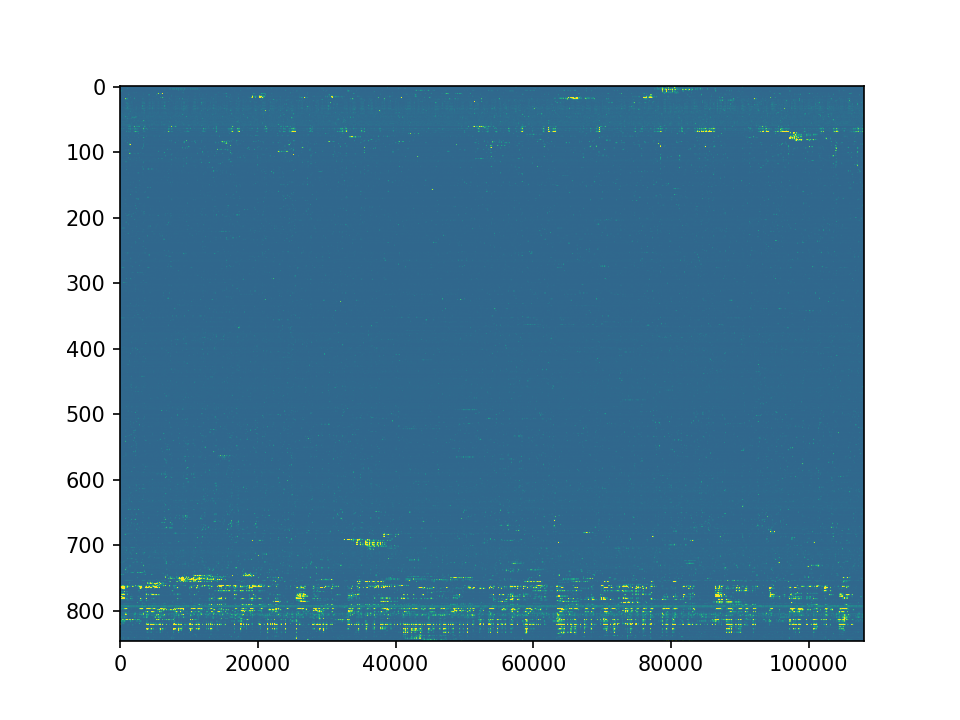

In [21]:
%matplotlib notebook

plt.figure()
# plt.imshow(dFoF_sub_ptile[rmap.isort], aspect='auto', vmax=1)
# plt.imshow(np.clip(scipy.stats.zscore(dFoF_sub_ptile, axis=1), -1,1)[rmap.isort], aspect='auto', vmax=1)
plt.imshow(dFoF_sub_ptile_clipped[rmap.isort], aspect='auto', vmin=-0.2, vmax=1)
# plt.imshow(scipy.stats.zscore(dFoF)[rmap.isort], aspect='auto', vmin=-0.1, vmax=1)

# Run SPCA

In [29]:
# neural_data_toUse =dFoF / np.std(dFoF,axis=1,keepdims=True)
# neural_data_toUse = (dFoF_sub_ptile / np.std(dFoF_sub_ptile,axis=1,keepdims=True))[:,indices_cropped]
neural_data_toUse = (dFoF_sub_ptile_clipped / np.std(dFoF_sub_ptile_clipped,axis=1,keepdims=True))

In [23]:
# neural_data_toUse = (dFoF_sub_ptile / np.std(dFoF_sub_ptile,axis=1,keepdims=True))
# neural_data_toUse = similarity.orthogonalize(neural_data_toUse.T, traces_toOrth)[0].T

# neural_data_toUse = np.clip(neural_data_toUse, a_min=0, a_max=None)

#### Orthogonalize avgVector out


In [30]:
# avgVector in neural_data_toUse space is supposed to be all-ones vector, but just to make sure...
avgVector = neural_data_toUse.std(1)[np.newaxis,:]
orthogonal_trace = ((avgVector @ neural_data_toUse) / (avgVector @ avgVector.T));
neural_data_toUse_ortho = neural_data_toUse - (avgVector.T * orthogonal_trace)
neural_data_toUse_ortho_centered = neural_data_toUse_ortho - neural_data_toUse_ortho.mean(1, keepdims=True)

In [57]:
isinstance(orthogonal_trace, np.ndarray)

True

In [32]:
import bnpm.similarity

In [34]:
test = bnpm.similarity.pairwise_orthogonalization_torch(neural_data_toUse.T, orthogonal_trace.squeeze())

In [67]:
orthogonal_vector.shape

(1, 108000)

<IPython.core.display.Javascript object>


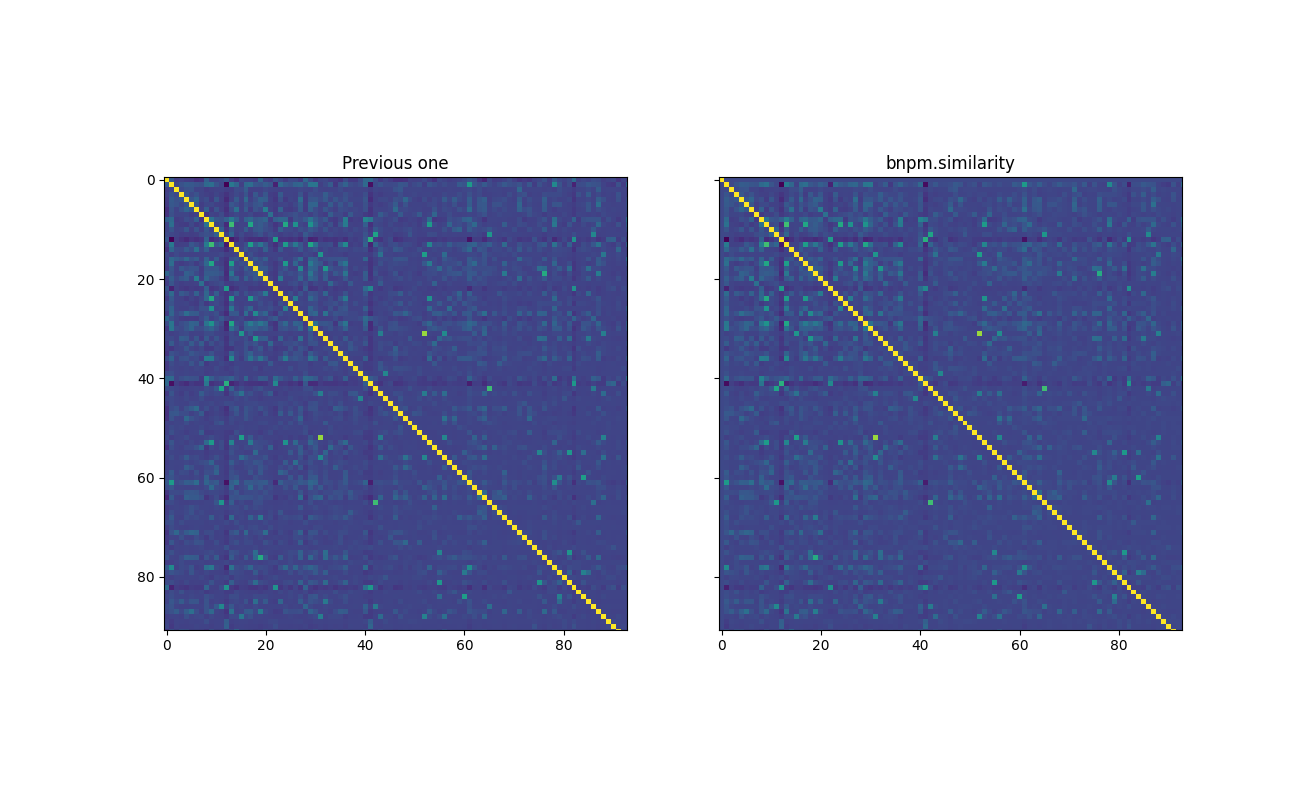

Text(0.5, 1.0, 'bnpm.similarity')

In [45]:
%matplotlib notebook
fig, axs = plt.subplots(1,2, sharex=True, sharey=True)
axs[0].imshow(np.corrcoef(orthogonal_trace, neural_data_toUse_ortho))
axs[0].set_title("Previous one")

axs[1].imshow(np.corrcoef(orthogonal_trace, test[0].T))
axs[1].set_title("bnpm.similarity")

<IPython.core.display.Javascript object>


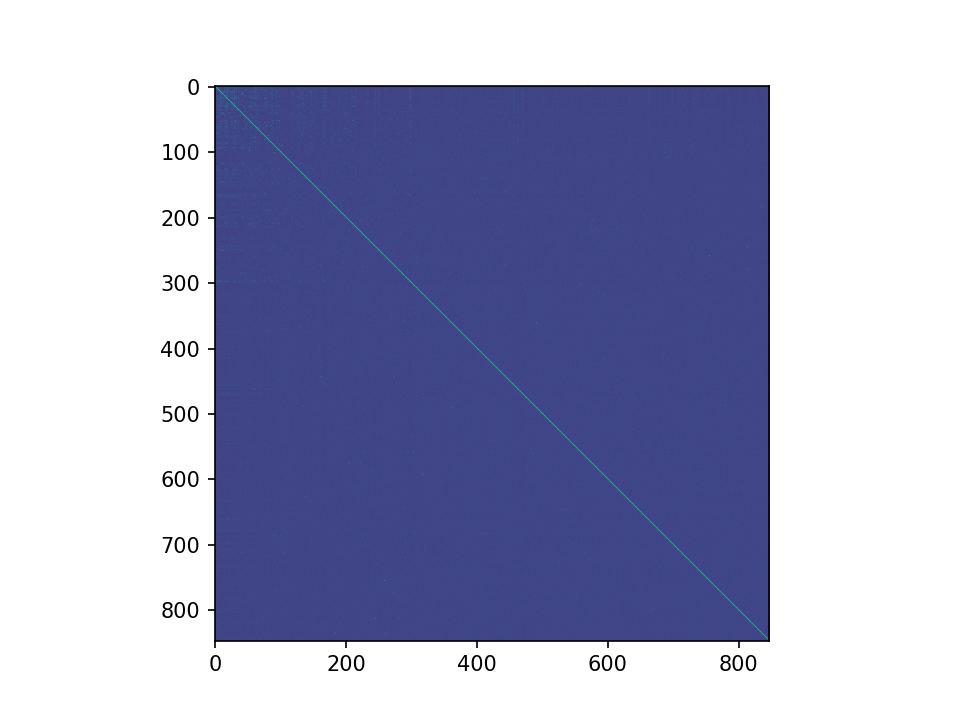

In [38]:
plt.figure()
plt.imshow(np.corrcoef(orthogonal_trace, neural_data_toUse_ortho))

<IPython.core.display.Javascript object>


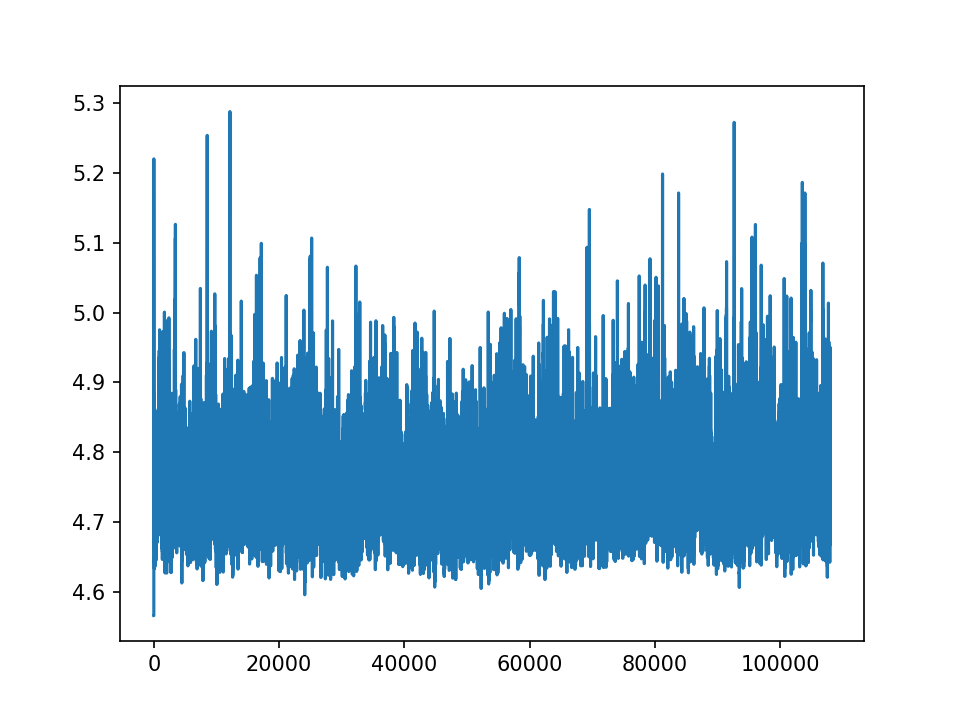

In [36]:
plt.figure()
plt.plot(orthogonal_vector.squeeze())

In [32]:
neural_data_toUse_ortho.shape

(846, 108000)

In [31]:
neural_data_toUse_ortho.mean(1)

array([-3.74113496e+00, -4.05508017e+00, -4.18418667e+00, -4.22068578e+00,
       -4.04677828e+00, -4.16006956e+00, -3.99121692e+00, -3.72173316e+00,
       -4.29014619e+00, -4.06795907e+00, -3.49526531e+00, -3.85275539e+00,
       -4.12417545e+00, -4.25586524e+00, -3.58410143e+00, -4.15917642e+00,
       -3.81840224e+00, -3.10028058e+00, -2.62803508e+00, -4.07587480e+00,
       -4.00694770e+00, -3.68164510e+00, -4.21681544e+00, -4.22162908e+00,
       -4.22111137e+00, -3.95876142e+00, -4.07494277e+00, -3.64381522e+00,
       -2.87211268e+00, -4.16358140e+00, -4.14753989e+00, -3.71241306e+00,
       -4.01497576e+00, -4.11768347e+00,  1.24882803e+00, -4.11491234e+00,
       -3.98365335e+00, -3.36051834e+00, -3.69526948e+00, -3.61803471e+00,
       -3.21709254e+00, -3.92762532e+00, -4.13386550e+00, -3.53438053e+00,
       -2.84232816e+00, -4.04490438e+00, -4.04888948e+00, -3.85802464e+00,
       -3.54117923e+00, -3.14535283e+00, -3.90008118e+00, -3.83950606e+00,
       -2.48339154e+00, -

In [25]:
neural_data_toUse_ortho.shape

(846, 108000)

<IPython.core.display.Javascript object>


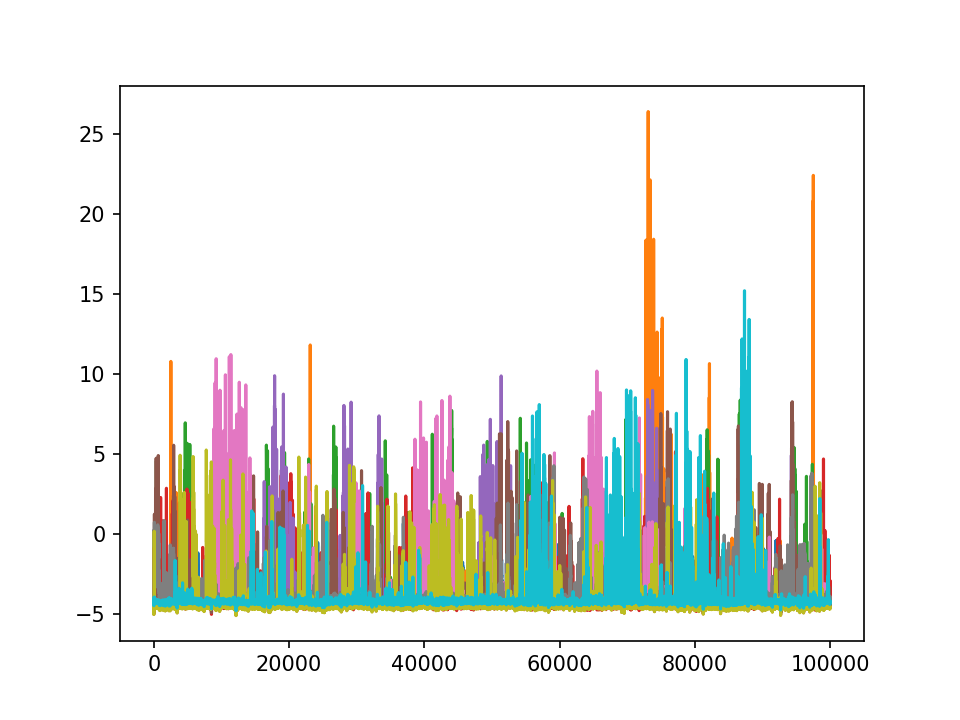

In [26]:
plt.figure()
for ii in range(10):
    plt.plot(neural_data_toUse_ortho[ii,:100000])

In [27]:
# Roll a dice and wish for luck
rank = 10

In [28]:
# Initialization method: np.linalg.svd(X, full_matrices=False)
SPCA = sklearn.decomposition.SparsePCA(n_components=rank,
                                             alpha=1,
                                             ridge_alpha=0.01,
                                             max_iter=100,
                                             tol=1e-08,
                                             method='lars',
                                             n_jobs=-1,
                                             U_init=None,
                                             V_init=None,
                                             verbose=True,
                                             random_state=None)

factors_SPCA = SPCA.fit_transform(neural_data_toUse_ortho_centered.T)

[dict_learning] ....................................................................................................

In [ ]:
# Initialization method: Manual PCA
PCA = sklearn.decomposition.PCA(n_components=rank,
                               copy=True,
                               whiten=False,
                               svd_solver='auto',
                               tol=0.0,
                               iterated_power='auto',
                               n_oversamples=10,
                               power_iteration_normalizer='auto',
                               random_state=None)

U_init = PCA.fit_transform(neural_data_toUse_ortho_centered.T)
V_init = PCA.components_

SPCA = sklearn.decomposition.SparsePCA(n_components=rank,
                                             alpha=1,
                                             ridge_alpha=0.01,
                                             max_iter=100,
                                             tol=1e-08,
                                             method='lars',
                                             n_jobs=-1,
                                             U_init=U_init,
                                             V_init=V_init,
                                             verbose=True,
                                             random_state=None)

factors_SPCA = SPCA.fit_transform(neural_data_toUse_ortho_centered.T)

In [29]:
factors_neuron_SPCA = SPCA.components_.T
factors_temporal_SPCA = factors_SPCA.T

# Run Regression

In [30]:
indices_to_use = np.arange(int(Fs*60*10),neural_data_toUse.shape[1])
## z-score SPCA  temporal factors
factors_temporal_SPCA_zscore = scipy.stats.zscore(factors_temporal_SPCA[:,indices_to_use],axis=1)

In [ ]:
## z-score neural data ORTHOGONAL to avgVector
neural_data_toUse_zscore = welford_moving_2D.make_rollingZScore(np.array(neural_data_toUse_ortho).T, win_roll=int(Fs*60*10)).T
neural_data_toUse_zscore = neural_data_toUse_zscore[:,indices_to_use]

In [ ]:
neural_data_toUse_zscore = scipy.stats.zscore(np.array(neural_data_toUse_ortho[:,indices_to_use]), axis=1)

In [ ]:
plt.figure()
for ii in range(10):
    plt.plot(neural_data_toUse_zscore[ii,:100000])

In [ ]:
## z-score neural data ORTHOGONAL to avgVector
neural_data_toUse_zscore = welford_moving_2D.make_rollingZScore(np.array(neural_data_toUse_ortho_centered).T, win_roll=int(Fs*60*10)).T
neural_data_toUse_zscore = neural_data_toUse_zscore[:,indices_to_use]

In [ ]:
plt.figure()
for ii in range(10):
    plt.plot(neural_data_toUse_zscore[ii,:100000])

In [ ]:
neural_data_toUse_zscore = np.nan_to_num(neural_data_toUse_zscore, nan=0)

In [ ]:
neural_data_toUse_zscore.shape

In [ ]:
%matplotlib notebook

plt.figure()
# plt.imshow(dFoF_sub_ptile[rmap.isort], aspect='auto', vmax=1)
plt.imshow(
    neural_data_toUse_zscore,
    aspect='auto',
    vmin=-1, 
    vmax=2,
)

In [ ]:
# OLS Regression
theta, factors_temporal_regression, bias = linear_regression.OLS(neural_data_toUse_zscore.T, factors_temporal_SPCA_zscore.T)
factors_temporal_regression = factors_temporal_regression.T

In [ ]:
# # Ridge Regression
# theta, factors_temporal_regression, bias = linear_regression.Ridge(neural_data_toUse_zscore.T, factors_temporal_SPCA_zscore.T, lam=100000)
# factors_temporal_regression = factors_temporal_regression.T

In [ ]:
# # ElasticNet Regression
# elr = sklearn.linear_model.ElasticNet(
#     alpha=0.1,
#     l1_ratio=0.05, 
#     fit_intercept=False,
# #     normalize='deprecated',
# #     precompute=False,
#     max_iter=1000, 
# #     copy_X=True, 
#     tol=0.0001,
# #     warm_start=False, 
#     positive=False,
#     random_state=42, 
#     selection='cyclic',
# #     verbose=True,
# )
# elr.fit(neural_data_toUse_zscore.T, factors_temporal_SPCA_zscore.T)

# theta = elr.coef_.T
# factors_temporal_regression = elr.predict(neural_data_toUse_zscore.T).T

In [ ]:
plt.figure()
plt.plot(np.arange(factors_temporal_SPCA_zscore.shape[1])/Fs,  factors_temporal_SPCA_zscore.T + 10*np.arange(rank)[None,:], alpha=0.3);
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_regression.shape[1])/Fs,  factors_temporal_regression.T + 10*np.arange(rank)[None,:]);

In [ ]:
similarity.EV(factors_temporal_SPCA_zscore.T, factors_temporal_regression.T)

In [ ]:
# Filter based on Explained Variance
# If we can't predict a factor well, don't keep it
ev_threshold = 0.7
_, pairwise, evr_weighted, _ = similarity.pairwise_orthogonalization(factors_temporal_regression.T.astype(np.float32), factors_temporal_SPCA_zscore.T.astype(np.float32))
factors_temporal_tokeep = factors_temporal_regression[pairwise > ev_threshold]

rank_good = (pairwise > ev_threshold).sum()
print(f'Rank above 0.7 EV: {rank_good}')

In [ ]:
pairwise

In [ ]:
# get evr for original? or zscored one?
_, _, evrs = get_highest_evr_var(neural_data_toUse_ortho[:,indices_to_use].T, factors_temporal_tokeep,  np.ones(rank, bool))
# _, _, evrs = get_highest_evr_var(neural_data_toUse_zscore[:,indices_to_use].T, factors_temporal_tokeep,  np.ones(rank, bool))

In [ ]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs,  factors_temporal_SPCA_zscore[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs,  factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good));

In [ ]:
weights = theta[:,np.argsort(evrs)[::-1]]
# weights = theta
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

%matplotlib notebook
display_toggle_image_stack(
    sf_weights, 
    clim=[sf_weights.min(), sf_weights.max()]
)

# Run temporal factor Orthogonalization

In [ ]:
factors_orth = copy.deepcopy(factors_temporal_tokeep)
num_factors = rank_good
hits = np.ones(num_factors, bool)
for i in range(num_factors-1):
    ind_to_orthogonalize, factor_to_orthogonalize, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth, hits)
    print(f'Factor at {ind_to_orthogonalize} index explains {evrs[ind_to_orthogonalize]} of the variance in neural data')
    hits[ind_to_orthogonalize] = False
    factors_orth[hits] = np.transpose(orthogonalize_simple(factors_orth[hits].T, factor_to_orthogonalize))

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(factors_temporal_tokeep),vmin=-1)
ax2.imshow(np.corrcoef(factors_orth),vmin=-1)

In [ ]:
_, _, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth,  np.ones(num_factors, bool))

In [ ]:
np.sort(evrs)

# Run Regression Pt 2

In [ ]:
# OLS Regression
theta, factors_orth_regression, bias = linear_regression.OLS(neural_data_toUse_zscore.T, factors_orth.T)
factors_orth_regression = factors_orth_regression.T

In [ ]:
_, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].T, factors_orth,  np.ones(num_factors, bool))

In [ ]:
plt.figure()
plt.plot(np.sort(evrs)[::-1])

# Visualize

In [ ]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good))

In [ ]:
weights = theta[:,np.argsort(evrs)[::-1]]
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

factors_orth_regression_sorted = factors_orth_regression[np.argsort(evrs)[::-1]]

%matplotlib notebook
display_toggle_image_stack(sf_weights)

In [ ]:
weights_zeroSum = weights - weights.mean(0)

In [ ]:
plt.figure()
plt.imshow(neural_data_toUse_zscore, aspect='auto', vmax=4)

In [ ]:
%matplotlib notebook
plt.figure()
plt.imshow(theta[:,:],aspect='auto', interpolation='none')

In [ ]:
%matplotlib notebook
plt.figure()
plt.imshow(weights_zeroSum[:,:],aspect='auto', interpolation='none')

# Save it all

In [ ]:
factor_to_use = 0 # 0-indexed
weights = theta[:,np.argsort(evrs)[::-1]]

weights_day0 = {
    "weights": weights_zeroSum[:,factor_to_use],
    "weights_all" : weights_zeroSum,
    "factors_neural": weights
    "iscell_custom": iscell,
    "factor_to_use": factor_to_use,
    "sf_weights": sf_weights,
#     "factors_temporal": factors_temporal_tokeep,
    "factors_temporal": factors_orth_regression_sorted,
}


F = scipy.io.savemat(path_save.with_suffix('.mat') , weights_day0)

np.save(path_save.with_suffix('.npy') , weights_day0)

# Load in old outputs

In [ ]:
import numpy as np

In [ ]:
data = np.load(r'D:/RH_local/data/BMI_cage_1511_4/mouse_1511L/20230111/analysis_data/weights_day0.npy', allow_pickle=True)[()]

In [ ]:
data.keys()

In [ ]:
import bnpm.plotting_helpers

In [ ]:
# weights = theta[:,np.argsort(evrs)[::-1]]
# sf_weights = np.einsum('ij,ikl->jkl', data['weights_all'], sf[data['iscell_custom']])

%matplotlib notebook
bnpm.plotting_helpers.display_toggle_image_stack(data['sf_weights'])